# Analisis de Reservas de un hotel

* #####  En esta ocasion se analisará y se destacará patrones de reservas que son canceladas. De esta forma ayudar a la empresa a tomar decisiones para mejorar en el area

### <P style="color:rgb(150,30,95);font-size:30px"> <b> HIPOTESIS </b></P>

- Las tarifas elevadas pueden ser una causa de arrepentimiento en las reservas
- El periodo o época del año, puede causar que las cancelaciones aumenten
- El metodo de compra Online, sugiere una facilidad al cancelar la reserva, suponiendo que el metodo Offline, requiere trasladarse al lugar o llamar para cancelar la misma
- La oferta gastronomica simple puede impactar en la cantidad de cancelaciones
- El tiempo en lista de espera puede ser crucial al momento de mantener una reserva.

### Importamos las librerias a utilizar

* El dataset utilizado se encuentra en el siguiente enlance: <a href="https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand">Booking Dataset</a>

In [38]:
import pandas as pd #Analisis de datos
import matplotlib.pyplot as plt #Creacion de dashboards
import seaborn as sns #Creacion de dashboards
import warnings #Ignorar advertencias 
from bs4 import BeautifulSoup # Web-Scrapping
import requests 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [39]:
# Lectura del dataset
booking = pd.read_csv('hotel_bookings.csv')
booking.shape

(119390, 32)

In [40]:
# Realizamos una copia para no afectar el dataset original
booking_copy = booking.copy()

In [41]:
# Visualizacion de los primeros datos
booking_copy.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/7/2015


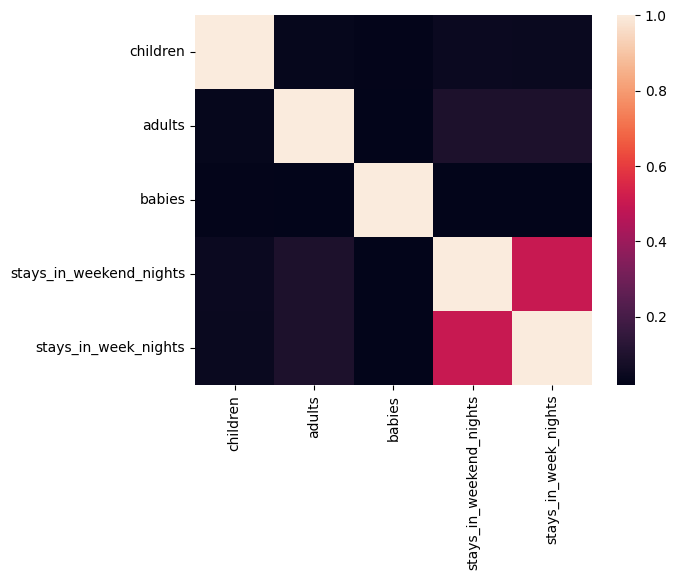

In [42]:
# Analisis de correlaciones
corr = booking_copy[["children","adults","babies",'stays_in_weekend_nights',"stays_in_week_nights"]].corr()
sns.heatmap(corr)
plt.show()

- De momento el gráfico anterior no nos proporciona gran valor

### <p style="color:rgb(100,200,200)"> <b>Primeros pasos</b></p>

1) Eliminacion de columnas en caso de poseer gran cantidad de nulos.

2) Chequeo del tipo de dato.

3) Cambio de valores para que sean más explicitos en caso de ser necesario.

4) Scrapping para conocer a que pais hace referencia la columna `country`.

1. <p style="color:rgb(180,100,180)"><i> Chequeo de nulos. </i> </p>

In [43]:
booking_copy.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

- Como se puede observar la columna `company` posee gran cantidad de nulos con respecto la cantidad total de registros del <i>Dataset</i>. Por estos motivos, será eliminada

In [44]:
booking_copy.drop(columns="company", inplace=True)

2. <p style="color:rgb(180,100,180)"><i> Chequeo del tipo de dato. </i> </p>

In [45]:
booking_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [46]:
# Columna reservation_status_date sera cambiada a tipo fecha.

booking_copy["reservation_status_date"] = pd.to_datetime(booking_copy["reservation_status_date"], format="%d/%m/%Y")


3. <p style="color:rgb(180,100,180)"> En esta ocasion cambiaremos los valores de la columna <b> meal </b> para que sean más especificos y faciles de entender</p>

<b>Los valores son:</b>

- SC (Self-Catering):  Cada quien se cocina sus propias comidas
- BB: (Bed & Breakfast) Incluye desayuno
- HB: (Half Board) Desayuno y una comida más
- FB: (Full Board) Desayuno, Almuerzo y Cena
- Undefined: No está definido

In [47]:
booking_copy.meal.unique(), booking_copy.meal.value_counts(normalize=True)

(array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object),
 meal
 BB           0.773180
 HB           0.121141
 SC           0.089203
 Undefined    0.009791
 FB           0.006684
 Name: proportion, dtype: float64)

* Como los valores *undefined* no representan gran porcentaje de los datos(solo el 0.9%), se los agrupara con ***self-catering***, ya que podriamos suponer que si un hotel no especifica si incluye las comidas, podriamos decir este no lo hace. <b>Siempre contactarse con el/la dueñ@ de los datos ante la duda.</b>

In [48]:
# Diccionario para reemplazar valores

meals = {
    "BB": "Bread & Breakfast",
    "HB": "Haf-Board",
    "FB": "Full-Board",
    "SC": "Self-Catering",
    "Undefined":"Self-Catering"
}

booking_copy["meal"].replace(meals,inplace=True)

booking_copy.meal.unique()

array(['Bread & Breakfast', 'Full-Board', 'Haf-Board', 'Self-Catering'],
      dtype=object)

3. <p style="color:rgb(180,100,180)">Web Scrapping para traer los nombres completos de los paises</p>

In [49]:
def get_countries():
    countries_page = requests.get('https://www.iban.com/country-codes').text #Pagina que lista los paises junto a su código

    countries_soup = BeautifulSoup(countries_page, "html.parser")

    countries_table = countries_soup.find('tbody') #Buscamos el elemento que contiene los paises

    countries_rows = countries_table.find_all("tr") # Buscamos las filas a iterar

    countries = {}

    for country in countries_rows:

        country_list = country.get_text().strip().split("\n")
        countries[country_list[2]] = country_list[0]

    return countries

countries = get_countries()
countries

{'AFG': 'Afghanistan',
 'ALA': 'Åland Islands',
 'ALB': 'Albania',
 'DZA': 'Algeria',
 'ASM': 'American Samoa',
 'AND': 'Andorra',
 'AGO': 'Angola',
 'AIA': 'Anguilla',
 'ATA': 'Antarctica',
 'ATG': 'Antigua and Barbuda',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'ABW': 'Aruba',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BHS': 'Bahamas (the)',
 'BHR': 'Bahrain',
 'BGD': 'Bangladesh',
 'BRB': 'Barbados',
 'BLR': 'Belarus',
 'BEL': 'Belgium',
 'BLZ': 'Belize',
 'BEN': 'Benin',
 'BMU': 'Bermuda',
 'BTN': 'Bhutan',
 'BOL': 'Bolivia (Plurinational State of)',
 'BES': 'Bonaire, Sint Eustatius and Saba',
 'BIH': 'Bosnia and Herzegovina',
 'BWA': 'Botswana',
 'BVT': 'Bouvet Island',
 'BRA': 'Brazil',
 'IOT': 'British Indian Ocean Territory (the)',
 'BRN': 'Brunei Darussalam',
 'BGR': 'Bulgaria',
 'BFA': 'Burkina Faso',
 'BDI': 'Burundi',
 'CPV': 'Cabo Verde',
 'KHM': 'Cambodia',
 'CMR': 'Cameroon',
 'CAN': 'Canada',
 'CYM': 'Cayman Islands (the)',
 'CAF': 'Central African R

In [50]:
# Definimos los valores de la columna que seran reemplazados

booking_copy["country"].replace(countries, inplace=True)

In [51]:
booking_copy.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,Bread & Breakfast,Portugal,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,Bread & Breakfast,Portugal,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


### <u> Tratamiento de outliers </u>

In [52]:
booking_copy.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,2.321149,101.831122,0.062518,0.571363,2016-07-30 00:24:47.883407104
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,69.290000,0.000000,0.000000,2016-02-01 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,94.575000,0.000000,0.000000,2016-08-07 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,0.000000,126.000000,0.000000,1.000000,2017-02-08 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,17.594721,50.535790,0.245291,0.792798,NaN


In [53]:
booking_copy.describe(include='object') # Realizamos el describe de las columnas de tipo objeto

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390
unique,2,12,4,177,8,5,10,12,3,4,3
top,City Hotel,August,Bread & Breakfast,Portugal,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166


- Realizaremos un ***boxplot*** en las columnas `adults`, `adr` (Average Day Rate), `children`,`babies`. Se encontraron valores maximos y/o minimos atipicos.

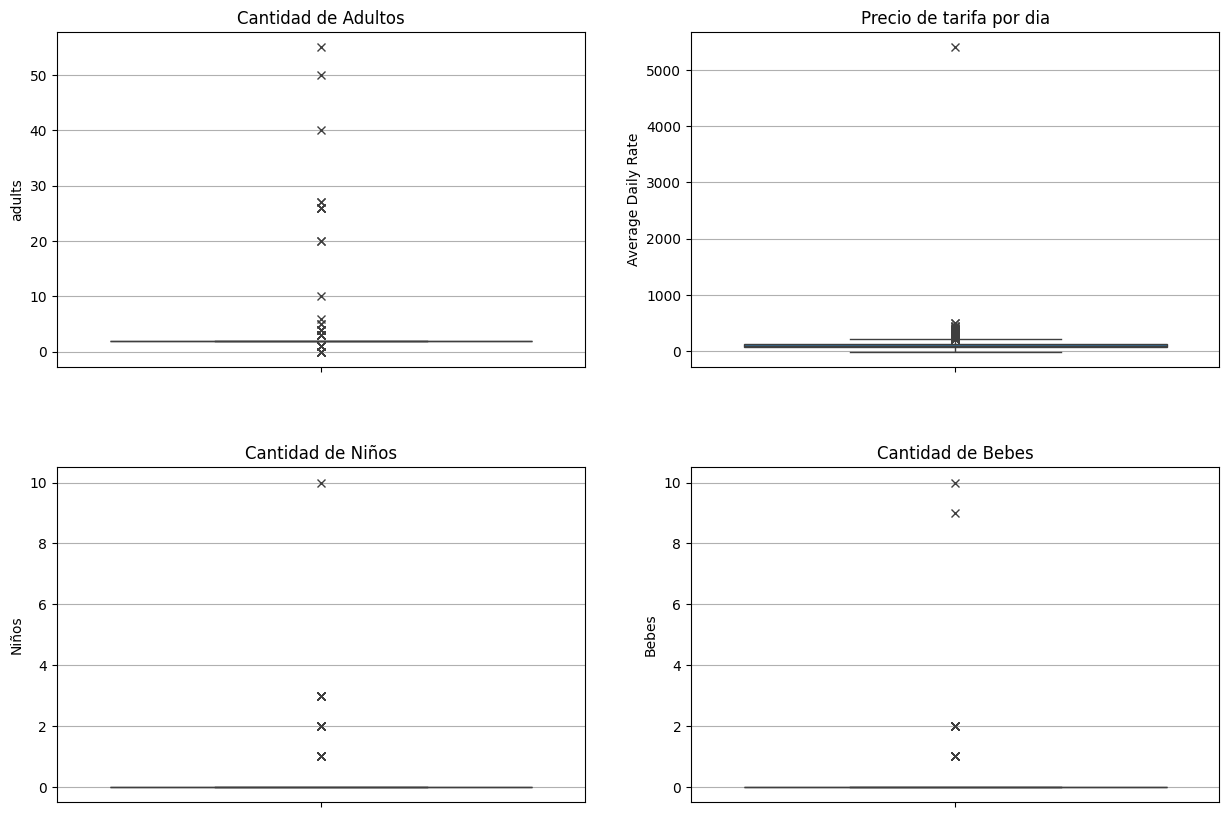

In [54]:
fig,ax = plt.subplots(2,2, figsize= (15,10))
plt.subplots_adjust(hspace=.3) #Aumentamos el espacio en cada plot

#PLOT 1
ax[0,0].grid()
ax[0,0].set(title="Cantidad de Adultos")
sns.boxplot(data=booking_copy, flierprops={"marker": "x"},y="adults", ax=ax[0,0])


#PLOT 2
ax[0,1].grid()
ax[0,1].set(title="Precio de tarifa por dia", ylabel= "Average Daily Rate")
sns.boxplot(data=booking_copy,flierprops={"marker": "x"}, y="adr",ax=ax[0,1])

#PLOT 3
ax[1,0].grid()
ax[1,0].set(title="Cantidad de Niños", ylabel= "Niños")
sns.boxplot(data=booking_copy,flierprops={"marker": "x"}, y="children", ax=ax[1,0])

#PLOT 4
ax[1,1].grid()
ax[1,1].set(title="Cantidad de Bebes", ylabel= "Bebes")
sns.boxplot(data=booking_copy,flierprops={"marker": "x"}, y="babies", ax=ax[1,1])

plt.show()

- <p style="color:rgb(220,220,0)">Aclaracion:</p> El siguiente paso es realizado para ser más explicito, pero a simple viste se puede observar que no hay gran cantidad de outliers.

In [55]:
# Veremos que tantos registros ocupan de nuestro dataframe los outliers para ser eliminados

print(booking_copy[booking_copy["adults"] >= 20 ].shape[0])

print(booking_copy[(booking_copy["adr"] >= 400) | (booking_copy["adr"]<0)].shape[0])

print(booking_copy[booking_copy["children"] >= 4 ].shape[0])

print(booking_copy[booking_copy["babies"] >=4 ].shape[0])

12
9
1
2


- Utilizamos la funcion `query` para filtrar varias columnas a la vez.

In [56]:
booking_copy.query(expr="adults<20 & adr<400 & adr>0 & children <= 4 & babies <= 4", inplace=True)

### <u>Análisis y comportamiento de las reservas canceladas</u>

#### `0`: Se presento a la reserva
#### `1`: La reserva fue cancelada

In [74]:
# Porcentaje de reservas canceladas
#0: se presento a la reserva
#1: la reserva fue cancelada

booking_copy.is_canceled.value_counts(normalize=True) * 100

is_canceled
0    62.523528
1    37.476472
Name: proportion, dtype: float64

- Se puede oberservar que la mayoria de las reservas (un 62%) no fueron canceladas

#### <b> Reservas canceladas por tipo de hotel </b>

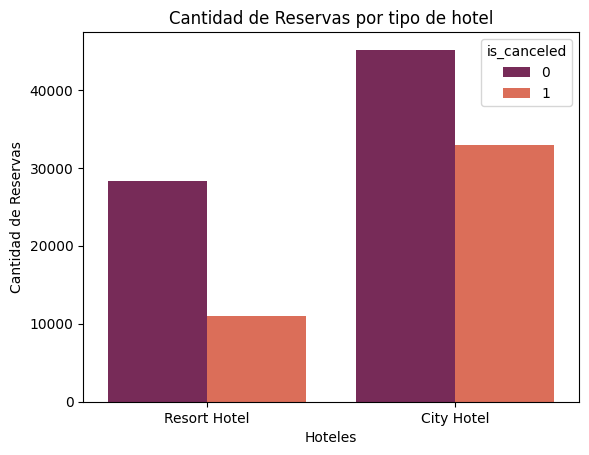

In [75]:
plt.title("Cantidad de Reservas por tipo de hotel")

plt.xlabel("Hoteles")
plt.ylabel("Cantidad de Reservas")

sns.countplot(data=booking_copy, x="hotel", hue="is_canceled",palette='rocket')

plt.show()

In [59]:
#Porcentaje del tipo de hotel que no fue cancelado
booking_copy[booking_copy["is_canceled"]==0]["hotel"].value_counts(normalize=True)

hotel
City Hotel      0.614954
Resort Hotel    0.385046
Name: proportion, dtype: float64

In [60]:
#Porcentaje del tipo de hotel que si fue cancelado
booking_copy[booking_copy["is_canceled"]==1]["hotel"].value_counts(normalize=True)

hotel
City Hotel      0.749222
Resort Hotel    0.250778
Name: proportion, dtype: float64

- Cuando tratamos las reservas canceladas, podemos notar que la direncia entre los dos tipo de hoteles es más abrupta.

#### <b> Reservas canceladas por mes </b>

* Dividir el *DataFrame* segun el mes para determinar en cual se realizan más cancelaciones (tendremos en cuenta la columna `reservation_status_date`)

In [61]:
booking_copy["month_name"] = booking_copy["reservation_status_date"].dt.month_name()
booking_copy["month_num"] = booking_copy["reservation_status_date"].dt.month

In [62]:
#Contar y ordenar los valores segun el numero de mes
month_booking = booking_copy[["month_num","month_name","is_canceled"]].value_counts().reset_index().sort_values(["month_num"])
month_booking

,month_num,month_name,is_canceled,count
11,1,January,0,4491
8,1,January,1,6031
13,2,February,1,4335
9,2,February,0,5011
6,3,March,0,6278
15,3,March,1,3803
5,4,April,0,6409
18,4,April,1,3457
19,5,May,1,3118
2,5,May,0,7002


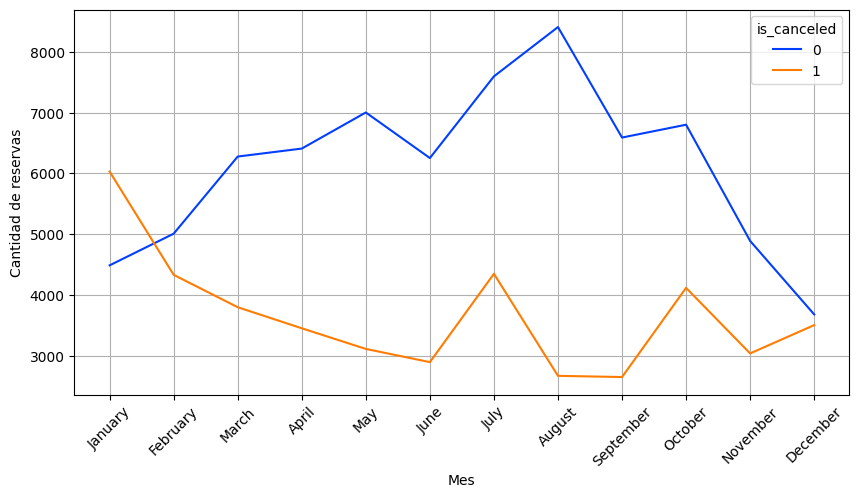

In [63]:
plt.figure(figsize=(10,5))
plt.xticks(rotation= 45)

plt.grid()

plt.xlabel("Mes")
plt.ylabel("Cantidad de reservas")

sns.lineplot(data=month_booking,x="month_name",y='count', hue="is_canceled",palette="bright")

plt.show()

#### <b> Reservas canceladas por mes: </b> Segun columna `adr` (Average Daily Price)

In [64]:
#Agrupamos segun el mes y la suma promedio del precio en la tarifa
adr_booking = pd.DataFrame(booking_copy.groupby(["month_num","month_name","is_canceled"])["adr"].sum().reset_index())
adr_booking

,month_num,month_name,is_canceled,adr
0,1,January,0,353353.85
1,1,January,1,571261.17
2,2,February,0,369589.39
3,2,February,1,447915.76
4,3,March,0,489982.03
5,3,March,1,424985.36
6,4,April,0,623771.23
7,4,April,1,425413.23
8,5,May,0,750436.29
9,5,May,1,391438.08


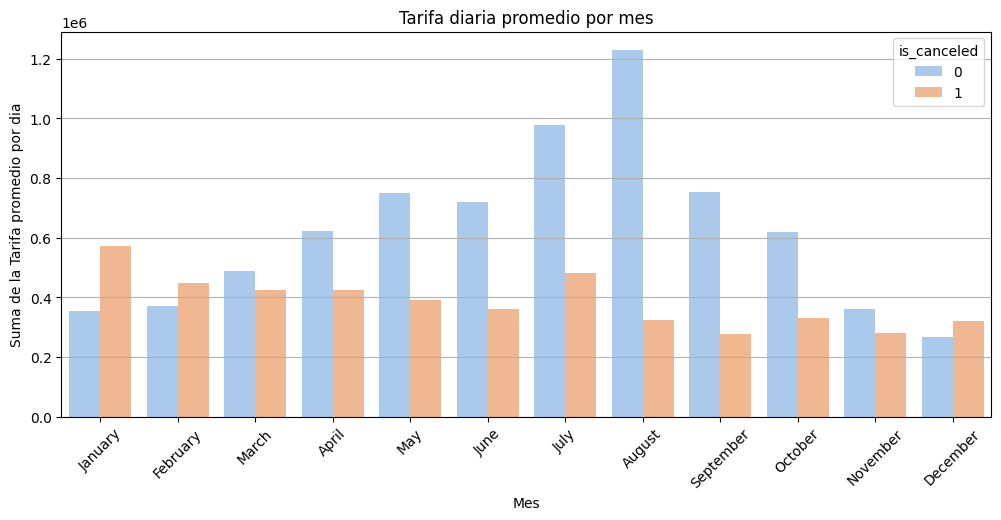

In [76]:
#Grafico de la tarifa diaria respecto al mes
plt.figure(figsize=(12,5))
plt.title("Tarifa diaria promedio por mes")

plt.xticks(rotation= 45)

plt.grid()

plt.xlabel("Mes")
plt.ylabel("Suma de la Tarifa promedio por dia")

sns.barplot(data=adr_booking,x='month_name',y='adr', hue='is_canceled',palette="pastel")

plt.show()

#### <b>Cancelaciones segun pais del hotel</b>

In [66]:
booking_copy["country"].replace({
    "United Kingdom of Great Britain and Northern Ireland (the)":"UK"
},inplace=True) #Reemplazo del nombre del pais por uno más corto
country = booking_copy["country"].value_counts().head(10)
country

country
Portugal             47028
UK                   12054
France               10360
Spain                 8488
Germany               7246
Italy                 3748
Ireland               3369
Belgium               2334
Brazil                2211
Netherlands (the)     2100
Name: count, dtype: int64

In [67]:
canceled = booking_copy[booking_copy['is_canceled']==1]
top_countries = canceled["country"].value_counts()[:5]
top_countries

country
Portugal    27324
UK           2451
Spain        2176
France       1932
Italy        1332
Name: count, dtype: int64

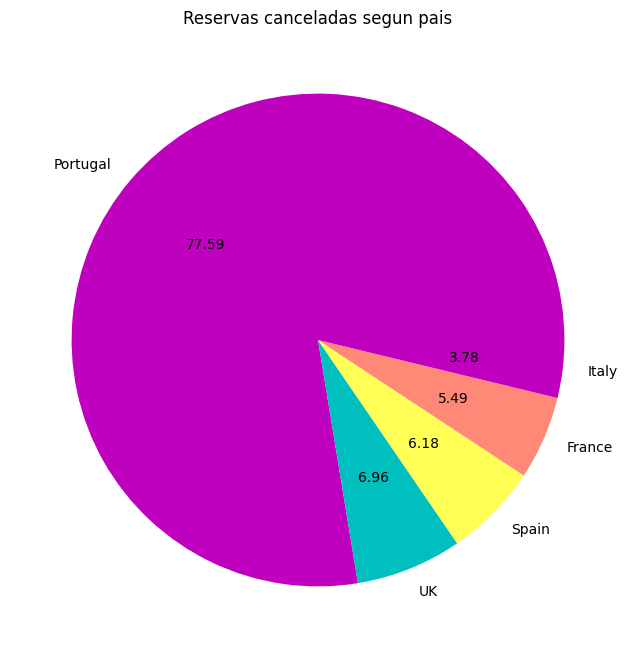

In [68]:
plt.figure(figsize= (10,8))
plt.title("Reservas canceladas segun pais")
plt.pie(top_countries,labels=top_countries.index, colors=["m","c","#ff5","#f87"],autopct='%.2f')
plt.show()

- <p style="color: rgb(200,200,30)">Aclaración:</p>

 `plt.pie` tenderá a aproximar los valores que le pasemos al 100%. Como solo le pasamos 5 valores y estos no llegan al 100%, el grafico se acomodara automaticamente.

#### <b>Cancelaciones basadas en la oferta gastronomica</b>

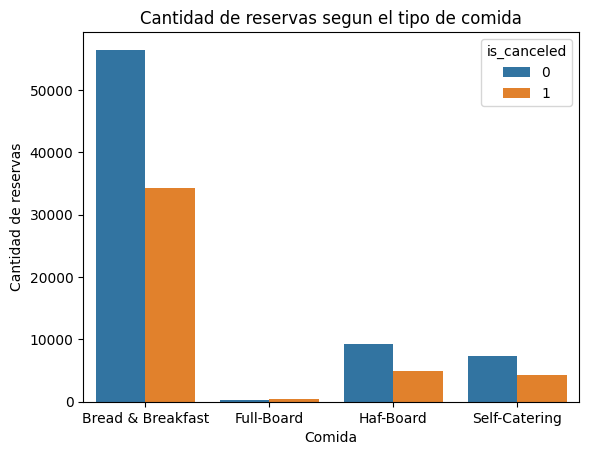

In [69]:
plt.title("Cantidad de reservas segun el tipo de comida")

sns.countplot(data=booking_copy, x='meal',hue='is_canceled')

plt.xlabel("Comida")
plt.ylabel("Cantidad de reservas")

plt.show()

- En esta ocasion no podemos suponer que la oferta gastronomica interfiere en las reservas, ya que todas las cancelaciones estan aproximadamente a la mitad de las que no fueron canceladas

In [70]:
# Canceled: Dataset de reservas canceladas
canceled.days_in_waiting_list.value_counts(ascending=False)[0:5]

days_in_waiting_list
0     41648
39      227
31      126
44      112
35       94
Name: count, dtype: int64

* Sin necesidad de realizar un grafico podemos notar que es indiferente si los dias de espera son superiores a 0 (cero), las reservas canceladas no tendran preferencia.

### Analisis del metodo de reserva (online o presencial)

In [71]:
# Buscamos los métodos que nos interesan: Online y Offline
booking_copy["market_segment"].unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO', 'Groups',
       'Complementary', 'Aviation'], dtype=object)

In [72]:
market = booking_copy[(booking_copy["market_segment"] == 'Online TA') | (booking_copy["market_segment"] ==  'Offline TA/TO') ]

market["market_segment"].value_counts(normalize=True)

market_segment
Online TA        0.701413
Offline TA/TO    0.298587
Name: proportion, dtype: float64

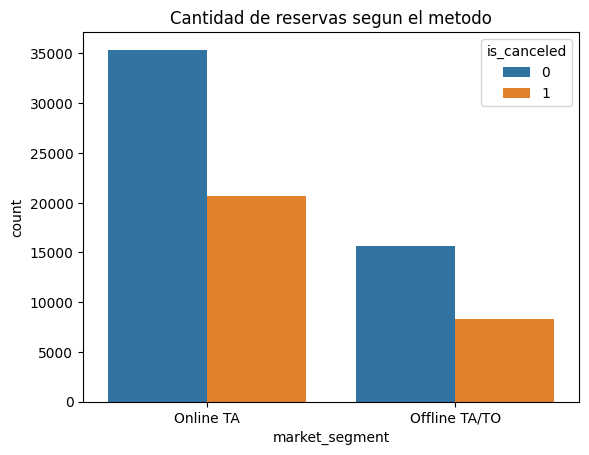

In [77]:
plt.title("Cantidad de reservas segun el metodo")

sns.countplot(data=market, x='market_segment', hue='is_canceled')
plt.show()

## Conclusiones:

- A pesar de que en la categoria <i>City Hotel</i> la cantidad de gente que acude es mayor, la categoria <i>Resort Hotel</i> presenta un mejor balance. Se podria realizar algunas promociones personalizadas durante dias de semana o meses especificos para atraer más gente a este tipo de hotel.

- Se pudo observar tanto en el primer trimestre como en la ultima parte del año, que por lo general, la cantidad de reservas canceladas equiparan a las reservas que no lo fueron. Sin embargo, podriamos suponer que en la mitad del año, las personas estan decidias a viajar, sin tener en cuenta el precio de la tarifa. Como sugerencia, recomendaria realizar los mismos pasos para aumentar los huespedes que en el paso anterior. Promociones, servicios incluidos, colaboraciones con otras empresas, etc.

- Con respecto a los paises, (suponiendo que estamos tratando una sola cadena de hoteles) las mejoras en la cede de Portugal, deberian ser iniciadas de inmediato.

- Si bien estos datos abarcan hasta el año 2017, es inminente que las personas prefieren hoy en dia optar por una reserva online. Es por eso que tener una pagina web es fundamental. Algunos de los pasos a tener en cuenta en una pagina web para atraer más clientes seria: programas de fidelizacion, beneficios exclusivo pagando el *pack premium*, sistema de puntos (simulando un juego), etc.

- Con respecto a los ultimos dos puntos (tiempo en la lista de espera y comidas incluidas), no presentan gran relevancia en si la reserva es cancelada o no, confirmando que una parte de la hipotesis, fue incorrecta.